# Introduction

This series of notebooks documents the analysis of microbiomes from various origins. The data were collected from 25 ponds, each belonging to one of five different experimental setups (see table below) that varied in probiotic supplementation.

For each pond, multiple samples were collected:

- Fish gut samples: Five samples from five individual fish.
- Sediment samples: Two samples per pond, collected at two different time points (refer to the sediment notebooks).
- Water samples: Three samples per pond, collected at three time points (refer to the H₂O notebooks).

  

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|



The 16S rRNA region of these samples was sequenced using the Illumina HiSeq 2000 platform. Subsequently, abundance tables for bacterial families, KEGG pathways, and KEGG orthologs were generated using the GGPicrust2 software.

The primary objectives of this analysis are to:

- Compare different approaches to classification analysis of the datasets.
- Develop an effective classification model capable of accurately distinguishing between experimental setups.

If you want to learn more [Here](https://theta.edu.pl/grants/common_carp/) you can find describtion of the full project on our website.

# Libraries import and data loading  



In [1]:
#libraries import
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping

from functions import *

np.random.seed(111)
tf.random.set_seed(111)

In [48]:
# load data from github 
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Deep-Learning-in-classification-of-common-Carp-intestine-classification/refs/heads/main/Data/Gut_bacteria_merged.csv')
print(f"shape:{df.shape}")
print(df.dtypes.value_counts())
df.head()

shape:(124, 127)
float64    126
object       1
Name: count, dtype: int64


pond  \
0  Gut_S10   
1  Gut_S10   
2  Gut_S10   
3  Gut_S10   
4  Gut_S10   

   d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae  \
0                                             2319.0                                   
1                                             3391.0                                   
2                                             1338.0                                   
3                                             1582.0                                   
4                                             1463.0                                   

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae  \
0                                             2187.0                                         
1                                             2071.0                                         
2                                             7053.0                                         
3                                            15595.0                                         
4                                             3891.0                                         

   d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae  \
0                                             1743.0                            
1                                              355.0                            
2                                              669.0                            
3                                              124.0                            
4                                              541.0                            

   d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae  \
0                                              500.0                            
1                                             1054.0                            
2                                              279.0                            
3                                              503.0                            
4                                                7.0                            

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae  \
0                                              521.0                                          
1                                             1024.0                                          
2                                              329.0                                          
3                                              309.0                                          
4                                               13.0                                          

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__  \
0                                              286.0            
1                                             1952.0            
2                                               63.0            
3                                                5.0            
4                                               11.0            

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae  \
0                                              366.0                                                
1                                               66.0                                                
2                                               52.0                                                
3                                             3418.0                                                
4                                               61.0                                                

   d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae  \
0                                              612.0                                       
1                                              217.0                                       
2       

Plotting missing values

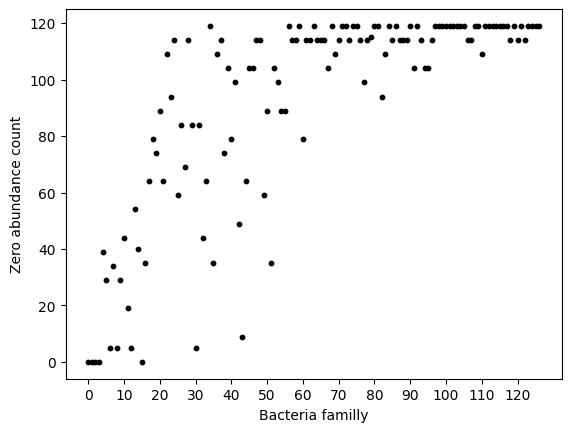

In [3]:
missing_values = df.isna().sum().reset_index()
xticks = list(range(0, len(missing_values), 10))
missing_values.columns = ['Column', 'MissingValues']
ax = missing_values.plot(kind='scatter', x='Column', y='MissingValues', s=10, color='black') 
#ax.title.set_text('Zero abundaance count')
ax.set_xlabel('Bacteria familly')
ax.set_ylabel('Zero abundance count')
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
plt.show()

Number of columns with only 5 observations

In [4]:
missing_values[missing_values['MissingValues'] > 118].shape

(39, 2)

We can note that we have a lot of missing values in our dataset this says that samples taken from different ponds are having differrent bacteria famillies, fortunetaly as missing values means that no bacteria of given familly was found we can replace missing values with zeroes.

In [5]:
df = df.fillna(0)
df.head()

pond  \
0  Gut_S10   
1  Gut_S10   
2  Gut_S10   
3  Gut_S10   
4  Gut_S10   

   d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae  \
0                                             2319.0                                   
1                                             3391.0                                   
2                                             1338.0                                   
3                                             1582.0                                   
4                                             1463.0                                   

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae  \
0                                             2187.0                                         
1                                             2071.0                                         
2                                             7053.0                                         
3                                            15595.0                                         
4                                             3891.0                                         

   d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae  \
0                                             1743.0                            
1                                              355.0                            
2                                              669.0                            
3                                              124.0                            
4                                              541.0                            

   d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae  \
0                                              500.0                            
1                                             1054.0                            
2                                              279.0                            
3                                              503.0                            
4                                                7.0                            

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae  \
0                                              521.0                                          
1                                             1024.0                                          
2                                              329.0                                          
3                                              309.0                                          
4                                               13.0                                          

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__  \
0                                              286.0            
1                                             1952.0            
2                                               63.0            
3                                                5.0            
4                                               11.0            

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae  \
0                                              366.0                                                
1                                               66.0                                                
2                                               52.0                                                
3                                             3418.0                                                
4                                               61.0                                                

   d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae  \
0                                              612.0                                       
1                                              217.0                                       
2       

In [6]:
maximum_values = df.max()
minumum_values = df.min()
range_values = maximum_values.iloc[1:] - minumum_values

In [7]:
# range_values.plot(kind='hist', figsize=(10, 6), color='skyblue', bins=100)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1320: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1327: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1335: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1336: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


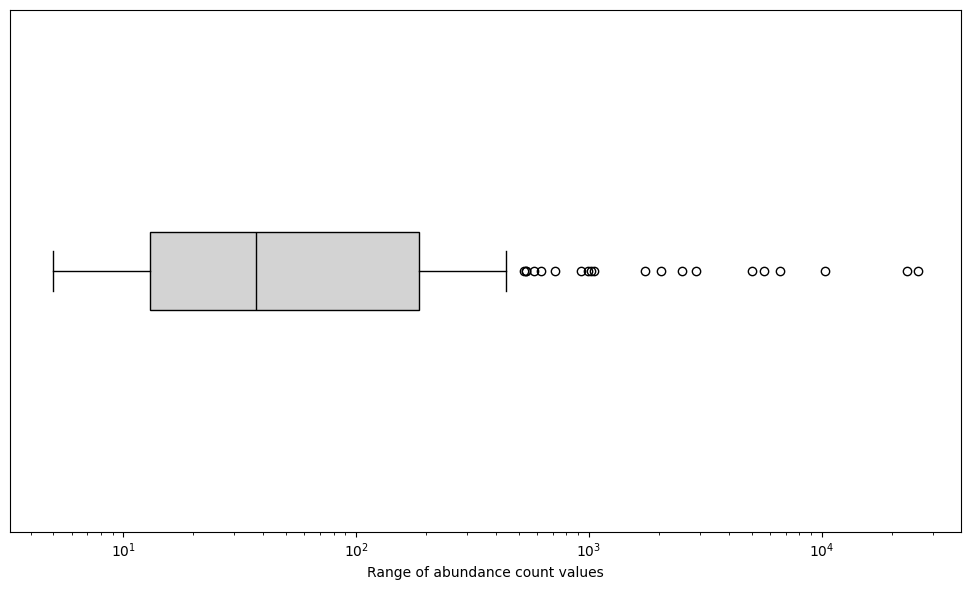

In [8]:
plt.figure(figsize=(10, 6))
plt.boxplot(
    range_values.values,
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor='lightgrey'),
    medianprops=dict(color='black', linewidth=1) 
)
plt.xscale('log') 
plt.xlabel('Range of abundance count values')
plt.tight_layout()
plt.yticks([]) 
plt.show()

Number of values with range exceeding 10k

In [9]:
range_values[range_values > 10000].count()

3

C:\Users\marek\AppData\Local\Temp\ipykernel_4252\2063846530.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


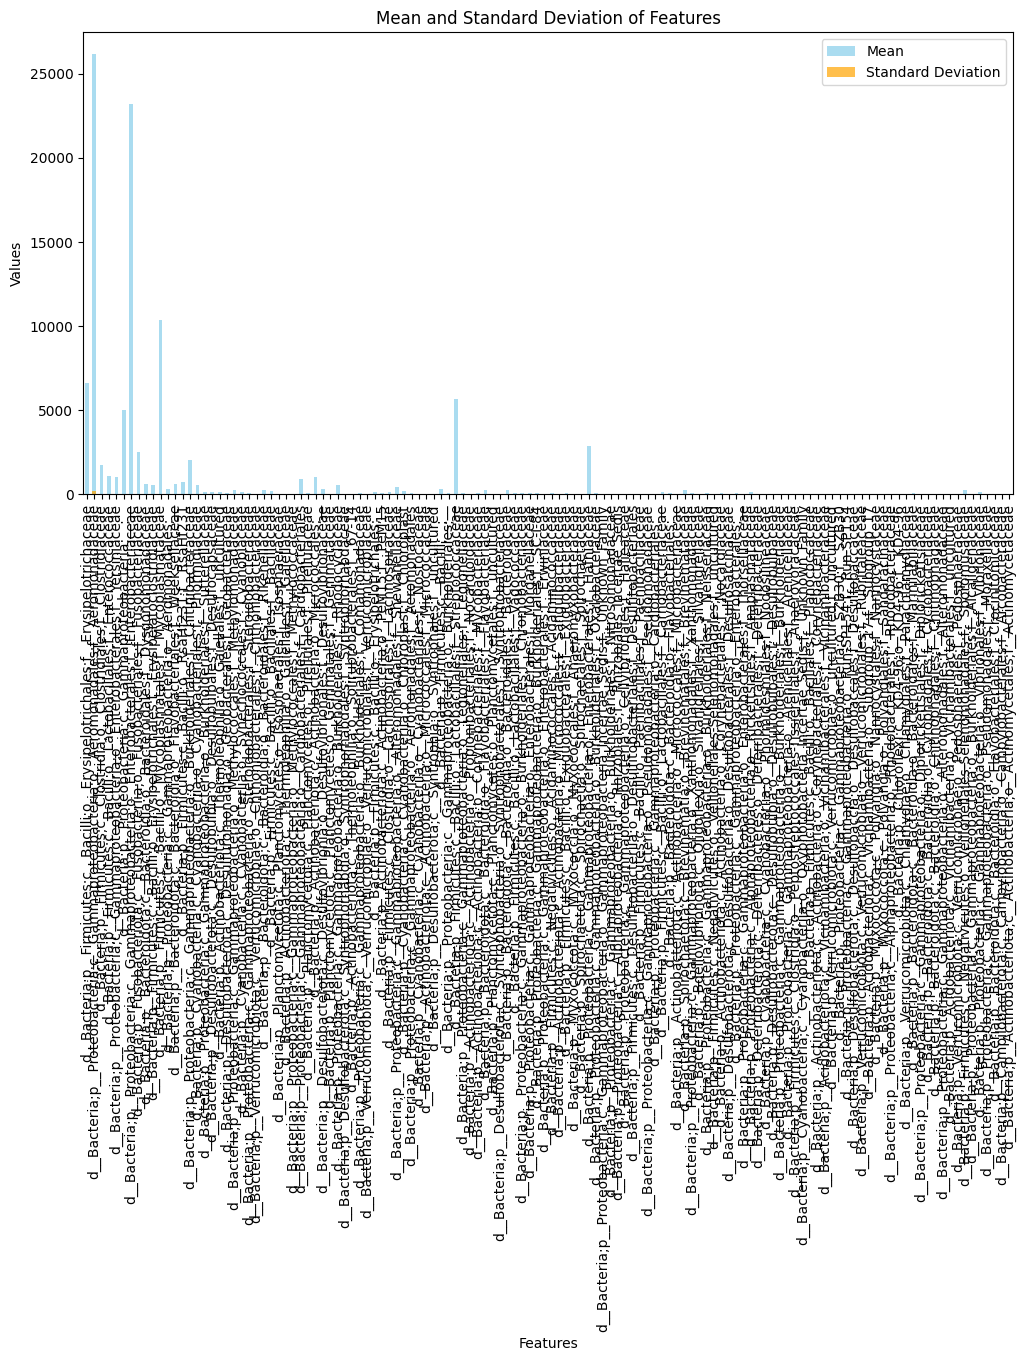

In [10]:
desc_stats = df.describe()
plt.figure(figsize=(12, 6))
desc_stats.loc['max'].plot(kind='bar', color='skyblue', alpha=0.7, label='Mean')
desc_stats.loc['min'].plot(kind='bar', color='orange', alpha=0.7, label='Standard Deviation')
plt.title('Mean and Standard Deviation of Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

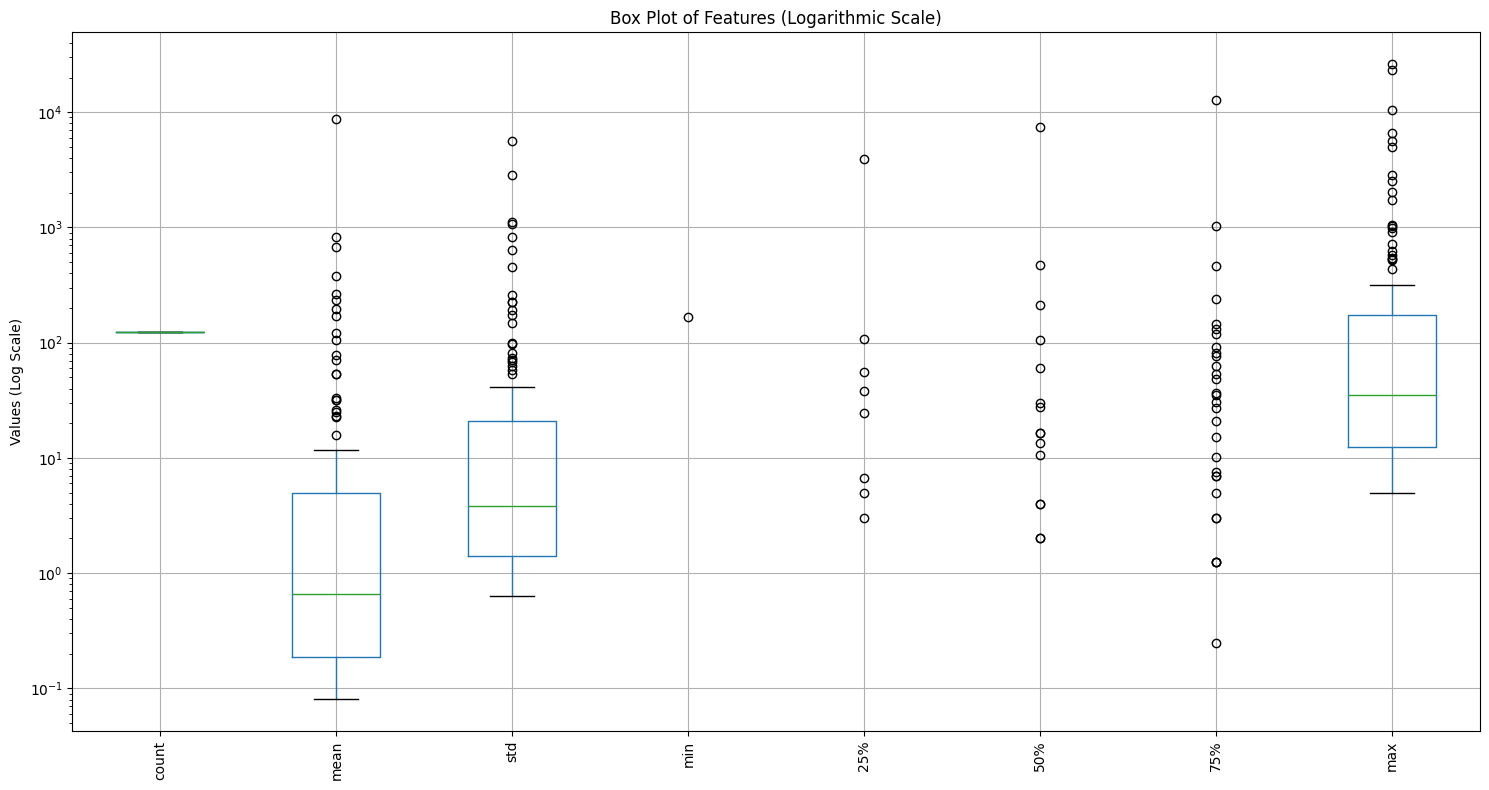

In [11]:
plt.figure(figsize=(15, 8))
df.describe().T.boxplot()
plt.yscale('log')  
plt.title('Box Plot of Features (Logarithmic Scale)')
plt.xticks(rotation=90)
plt.ylabel('Values (Log Scale)')
plt.tight_layout()
plt.show()

After seeing some basic statistics regarding columns we can see that range of valueus varries a lot we should normalise collumns (features).
We should also perform conversion of class variable to assign samples from different ponds to class used later for training of the model.

### Conversion of class variable


Explanation of pond coding

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [12]:
predictors = df.columns[1:]
print(f"Number of predictors: {len(predictors)}")

Number of predictors: 126


In [13]:
predictors

Index(['d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae',
       'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae',
       'd__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae',
       'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae',
       'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae',
       'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__',
       'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae',
       'd__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae',
       'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae',
       'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae',
       ...
       'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alterom

In [14]:
df.head()

pond  \
0  Gut_S10   
1  Gut_S10   
2  Gut_S10   
3  Gut_S10   
4  Gut_S10   

   d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae  \
0                                             2319.0                                   
1                                             3391.0                                   
2                                             1338.0                                   
3                                             1582.0                                   
4                                             1463.0                                   

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae  \
0                                             2187.0                                         
1                                             2071.0                                         
2                                             7053.0                                         
3                                            15595.0                                         
4                                             3891.0                                         

   d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae  \
0                                             1743.0                            
1                                              355.0                            
2                                              669.0                            
3                                              124.0                            
4                                              541.0                            

   d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae  \
0                                              500.0                            
1                                             1054.0                            
2                                              279.0                            
3                                              503.0                            
4                                                7.0                            

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae  \
0                                              521.0                                          
1                                             1024.0                                          
2                                              329.0                                          
3                                              309.0                                          
4                                               13.0                                          

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__  \
0                                              286.0            
1                                             1952.0            
2                                               63.0            
3                                                5.0            
4                                               11.0            

   d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae  \
0                                              366.0                                                
1                                               66.0                                                
2                                               52.0                                                
3                                             3418.0                                                
4                                               61.0                                                

   d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae  \
0                                              612.0                                       
1                                              217.0                                       
2       

In [15]:
# creating dataset splitted into 5 classes based on the pond 
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}
codes3 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26,9,13,17,20,27], 2 : [10,21,28,30,32,11,15,22,25,31]}
codes2 = {0 : [8,14,18,24,29,12,16,19,23,26,9,13,17,20,27], 1 : [10,21,28,30,32,11,15,22,25,31]}

df['pond_5'] = df['pond'].apply(lambda x: pond_decoder(x,codes))
df['pond_3'] = df['pond'].apply(lambda x: pond_decoder(x,codes3))
df['pond_2'] = df['pond'].apply(lambda x: pond_decoder(x,codes2))


In [16]:
df['pond_5'].value_counts()

pond_5
2    25
4    25
1    25
3    25
0    24
Name: count, dtype: int64

In [17]:
df[predictors]

d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae  \
0                                               2319.0                                   
1                                               3391.0                                   
2                                               1338.0                                   
3                                               1582.0                                   
4                                               1463.0                                   
..                                                 ...                                   
119                                              104.0                                   
120                                              750.0                                   
121                                              183.0                                   
122                                              490.0                                   
123                                               42.0                                   

     d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae  \
0                                               2187.0                                         
1                                               2071.0                                         
2                                               7053.0                                         
3                                              15595.0                                         
4                                               3891.0                                         
..                                                 ...                                         
119                                             9862.0                                         
120                                             3483.0                                         
121                                             1141.0                                         
122                                              167.0                                         
123                                             3597.0                                         

     d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae  \
0                                               1743.0                            
1                                                355.0                            
2                                                669.0                            
3                                                124.0                            
4                                                541.0                            
..                                                 ...                            
119                                              107.0                            
120                                              422.0                            
121                                              134.0                            
122                                                8.0                            
123                                               30.0                            

     d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae  \
0                                                500.0                            
1                                               1054.0                            
2                                                279.0                            
3                                                503.0                            
4                                                  7.0                            
..                                                 ...                            
119                                               20.0                            
120                                              381.0                            
121                        

## Applying CLR transformation

In [18]:
df[predictors] = pd.DataFrame(clr_manual(df[predictors]),columns = df[predictors].columns)

In [19]:
df

pond  \
0    Gut_S10   
1    Gut_S10   
2    Gut_S10   
3    Gut_S10   
4    Gut_S10   
..       ...   
119   Gut_S9   
120   Gut_S9   
121   Gut_S9   
122   Gut_S9   
123   Gut_S9   

     d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae  \
0                                             6.647672                                   
1                                             7.159550                                   
2                                             6.288459                                   
3                                             6.603987                                   
4                                             6.671165                                   
..                                                 ...                                   
119                                           4.248145                                   
120                                           5.952408                                   
121                                           4.691717                                   
122                                           5.780981                                   
123                                           3.229910                                   

     d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae  \
0                                             6.589093                                         
1                                             6.666644                                         
2                                             7.950131                                         
3                                             8.891680                                         
4                                             7.648916                                         
..                                                 ...                                         
119                                           8.790730                                         
120                                           7.486939                                         
121                                           6.517318                                         
122                                           4.708501                                         
123                                           7.656844                                         

     d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae  \
0                                             6.362286                            
1                                             4.905305                            
2                                             5.596058                            
3                                             4.065224                            
4                                             5.677504                            
..                                                 ...                            
119                                           4.276315                            
120                                           5.378375                            
121                                           4.382056                            
122                                           1.781762                            
123                                           2.902697                            

     d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae  \
0                                             5.114956                            
1                                             5.991671                            
2                                             4.723570                            
3                                             5.459487                            
4                                             1.461679                            
..                                                 ...                            
119

In [20]:
# saving the data
#df.to_csv('Gut_bacteria_clr.csv',index = False)


In [21]:
df.describe()

d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae  \
count                                         124.000000                                   
mean                                            5.184129                                   
std                                             1.444798                                   
min                                            -0.325684                                   
25%                                             4.245242                                   
50%                                             5.502807                                   
75%                                             6.197913                                   
max                                             7.913779                                   

       d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae  \
count                                         124.000000                                         
mean                                            8.149255                                         
std                                             1.072265                                         
min                                             4.708501                                         
25%                                             7.605297                                         
50%                                             8.190011                                         
75%                                             9.010625                                         
max                                             9.793854                                         

       d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae  \
count                                         124.000000                            
mean                                            3.644067                            
std                                             1.554761                            
min                                            -0.436293                            
25%                                             3.165891                            
50%                                             3.971892                            
75%                                             4.739503                            
max                                             6.362286                            

       d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae  \
count                                         124.000000                            
mean                                            1.438091                            
std                                             2.158231                            
min                                            -1.245936                            
25%                                            -0.408017                            
50%                                             0.400069                            
75%                                             3.659931                            
max                                             5.991671                            

       d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae  \
count                                         124.000000                                          
mean                                            1.940012                                          
std                                             2.209887                                          
min                                            -0.858576                                          
25%                                            -0.366712                                          
50%                                             2.041522                                          
75%                                             4.141260              

Here we can see results of normalisation as each feature is getting values in the same range (0:1). This helps model to treat each feature equaly regardless of its overall abundance. There is an argument against normalisation as more abundant bacteria should have more impact but normalisation proved to help with results.

## Splitting data into train and test sets


In [22]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=111, stratify=df['pond_5'], shuffle=True)
df_train_val.shape, df_test.shape

((99, 130), (25, 130))

At this point we have data ready for modeling with test size 20% of data, having 126 columns of bacteria abduance as predictor variables 99 reads as train set) and experimental setup as target varaible (1 column) with 5 classes we made sure that there is good representation of classes in each of datasets. In the next step we perform crossvalidation on our model.

# Model building, compiling, crossvalidating

Initial strategy as we have not much data is to have some more dropout to prevent overfitting and lower learning rate as well as more epochs to compensate for dropout.
- For loss function we will use [caterogical crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) as we have several encoded categories
- For metrics we will use [accuracy](https://keras.io/api/metrics/accuracy_metrics/) as it works well with our integer mutliclass predictor variable
- For optimizer we will chose Adam as it is an usual choice [optimzier choosing](https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e) we will set small learning rate at beggining but it might be that our network will rapidly stop learning becouse of that, in that case it is neccesary to update learning rate to bigger number


WE'd like to also introduce Confidence Score which is metric calculated by dividing the highest probability from the class probabilities vector returned by neural network by sum of rest of probabilities, it dedfines how much model is "sure" of its decisions and how we think is a nice addition to training statistics as it can help with defining robustness of the model.

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)

## model building and compiling
the following model is result of many trial and error atempts to create best classifier.  
 model with 2 hidedn layers with relu as an activation function. we have no values below zero/one so relu is predicting practically lineary but it is giving best results as sigmoid is too agresive and loss function is varring by a lot during training ("jumping"), also two dropout layers to prevent overfitting and one output layer with softmax activation function.

In [24]:
model1 = keras.Sequential()
model1.add(keras.layers.Dense(128, input_shape=(len(predictors),), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
model1.add(keras.layers.Dense(16, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))

model1.add(keras.layers.Dense(5, activation ='softmax'))

model1.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,637 (100.14 KB)

 Trainable params: 25,637 (100.14 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
loss = "categorical_crossentropy"
metrics = ["accuracy"]
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## Crossvalidation


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5000 - loss: 1.2530
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
predicted classes:       [1 3 4 0 2 0 0 1 3 3 1 4 4 4 1 2 4 0 4 4]
true validation classes: [3 3 1 2 2 0 1 1 3 1 1 4 2 4 0 2 4 1 3 2]
mean confidence score: 21.281, sd confidence score: 48.2139
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4000 - loss: 1.9260
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
predicted classes:       [3 4 1 4 4 2 2 2 3 4 4 3 4 4 4 3 3 0 2 0]
true validation classes: [0 0 0 2 4 0 0 2 3 0 1 3 4 4 0 2 3 1 2 1]
mean confidence score: 172.8226, sd confidence score: 452.231
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3500 - loss: 1.9181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predicted classes:       [4 3 3 2 0 1 4 3 1 0 1 3 4 4 2 3 3 3 4 3]
true validation classes: [1 1 2 2 0 4 0 3 0 4 3 1 4 2 2 1 3 1 4 1]
mean confidence score: 756.2529, sd confidence score: 2960

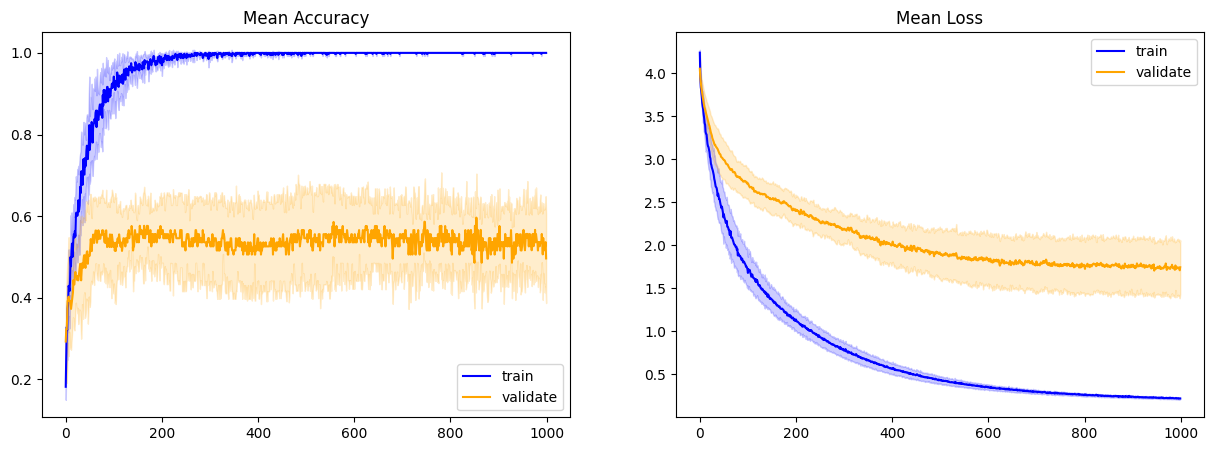

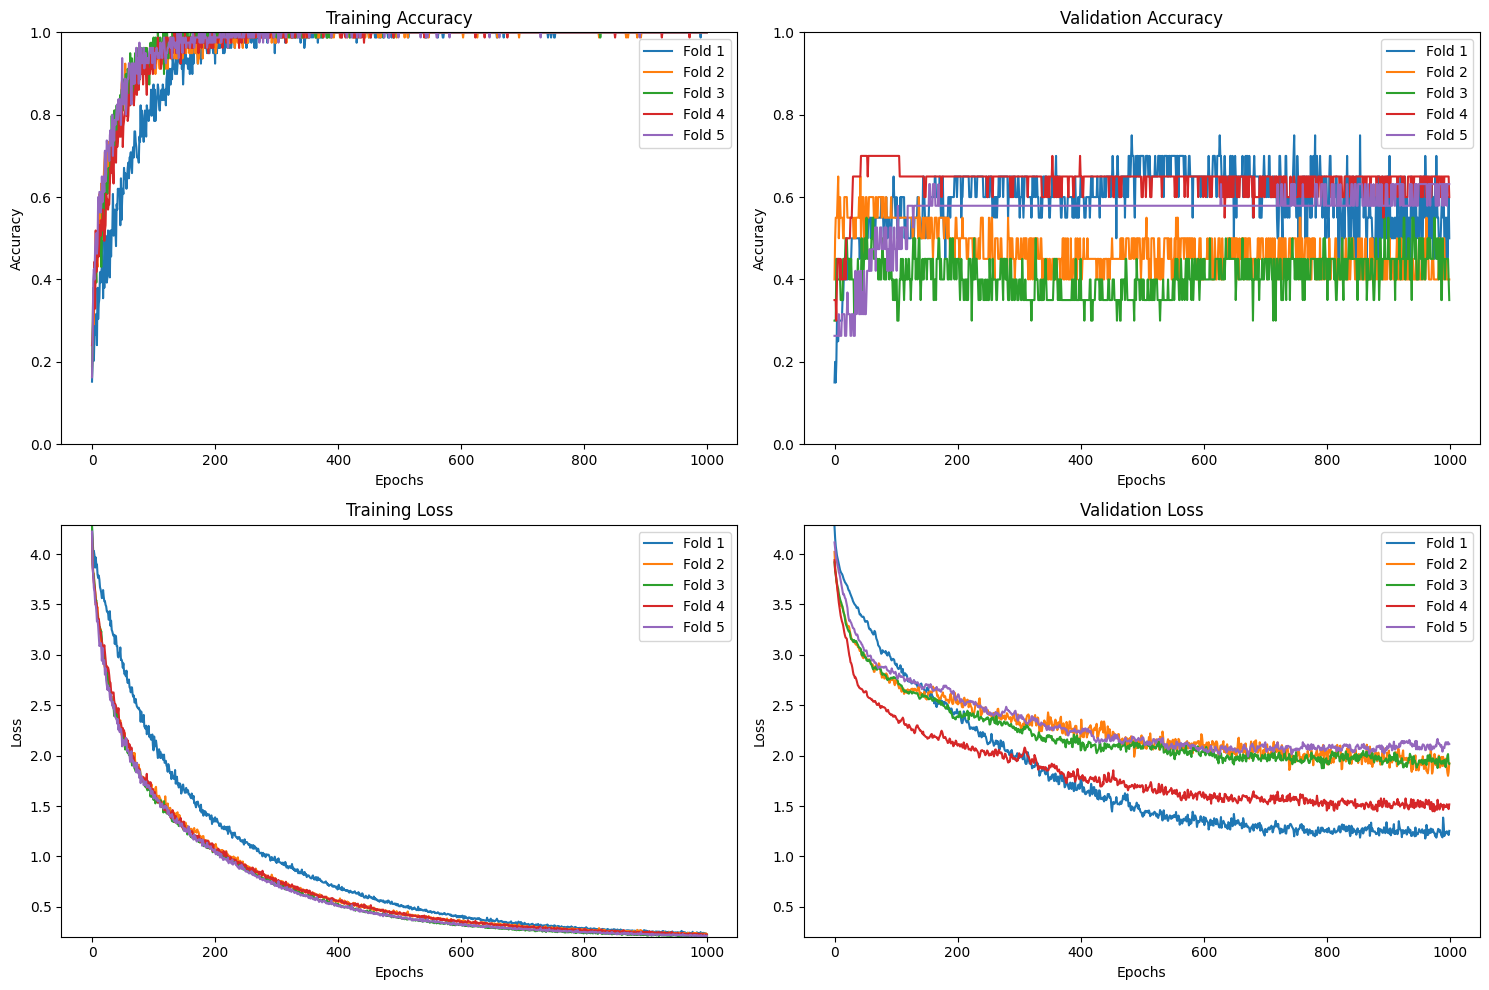

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [1 0 4 1 0 0 3 1 2 0 0 4 4 1 3 0 4 0 3]
true validation classes: [4 0 4 2 2 0 3 1 2 0 2 4 4 3 3 4 1 0 3]


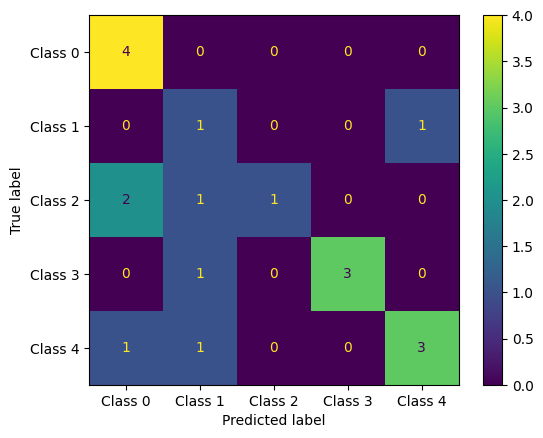

In [26]:
crossvalidate(df_train_val, model1, predictors,'pond_5', kf, epochs = 1000)

In [27]:
X_train = df_train_val[predictors].values
y_train = keras.utils.to_categorical(df_train_val['pond_5'].values)
X_test = df_test[predictors].values
y_test = keras.utils.to_categorical(df_test['pond_5'].values)

In [28]:
es = EarlyStopping(monitor='val_loss', patience=30)

In [29]:
reset_weights(model1)

In [30]:
history1=model1.fit(X_train, y_train, epochs = 1000, verbose = 0, shuffle = True, validation_data=(X_test, y_test), callbacks = [es])

# model evaluation
After model tuning on training / validation set its time we test it
we will start by extracting predicted classes from our predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7200 - loss: 1.1092
[1.109175443649292, 0.7200000286102295]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted values: [1 2 2 1 3 1 0 1 2 4 4 3 2 0 4 0 3 0 2 2 0 1 1 3 2]
True values: [3 0 2 1 3 1 0 1 2 2 4 3 4 0 4 1 3 0 2 4 0 1 4 3 2]


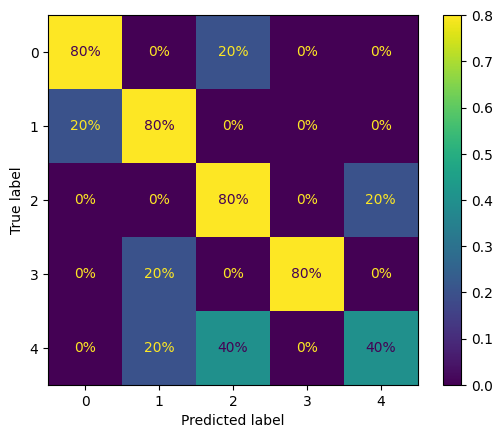

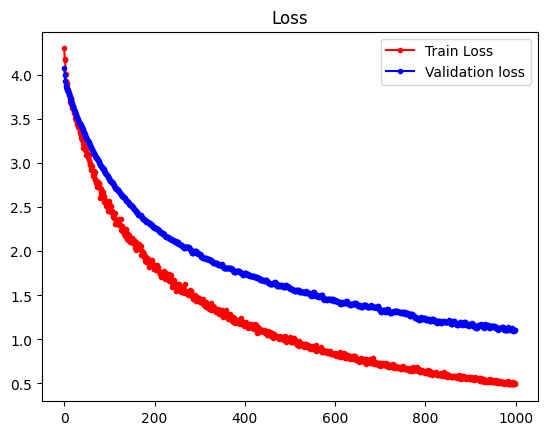

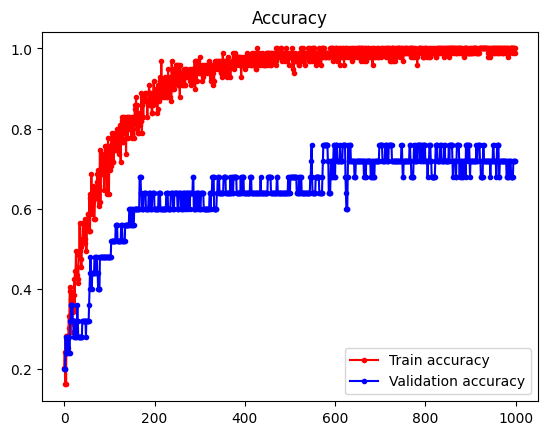

In [31]:
evaluate_model(model1, history1, X_test, y_test, acc_name = "Accuracy", loss_name = "Loss")

On those plots we can see that the results on test dataset are pretty bad which is interesting as crossvalidataion resuls seems to be quite better. Nevertheless test set accuracy barely excides random values. 

Explanation of pond coding

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

We will now perform class reduction based on biological asumptions, and we wil divide our set into 3 classes (controll, with feed supplementation, without feed supplementation)

# 3 classes
Here we will divide dataset into 3 classes 
0 - control (no water or feed suplementation)
1 - no feed suplementation 
2 - feed suplementation

In [32]:
y_train = keras.utils.to_categorical(df_train_val['pond_3'].values)
y_test = keras.utils.to_categorical(df_test['pond_3'].values)

In [33]:
df = df.copy()

## model building and compiling


In [34]:
model3 = keras.Sequential()
model3.add(keras.layers.Dense(128, input_shape=(len(predictors),), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
model3.add(keras.layers.Dense(16, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))

model3.add(keras.layers.Dense(3, activation ='softmax'))

model3.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,603 (100.01 KB)

 Trainable params: 25,603 (100.01 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## Crossvalidation


Number of classes: 3
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8000 - loss: 0.6718
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
predicted classes:       [1 1 2 2 2 2 0 1 1 1 1 2 2 2 1 2 2 1 1 2]
true validation classes: [1 1 1 2 2 0 1 1 1 1 1 2 2 2 0 2 2 1 1 2]
mean confidence score: 289.0491, sd confidence score: 803.3329
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6000 - loss: 1.6923
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted classes:       [1 2 2 2 2 2 2 2 1 2 0 1 2 2 2 2 1 1 2 1]
true validation classes: [0 0 0 2 2 0 0 2 1 0 1 1 2 2 0 2 1 1 2 1]
mean confidence score: 1466.9963, sd confidence score: 3705.4995
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8000 - loss: 0.9692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicted classes:       [1 1 1 2 0 1 2 1 1 2 1 1 2 2 2 1 1 1 2 1]
true validation classes: [1 1 2 2 0 2 0 1 0 2 1 1 2 2 2 1 1 1 2 1]
mean confidence score: 9185.7324, sd confidence scor

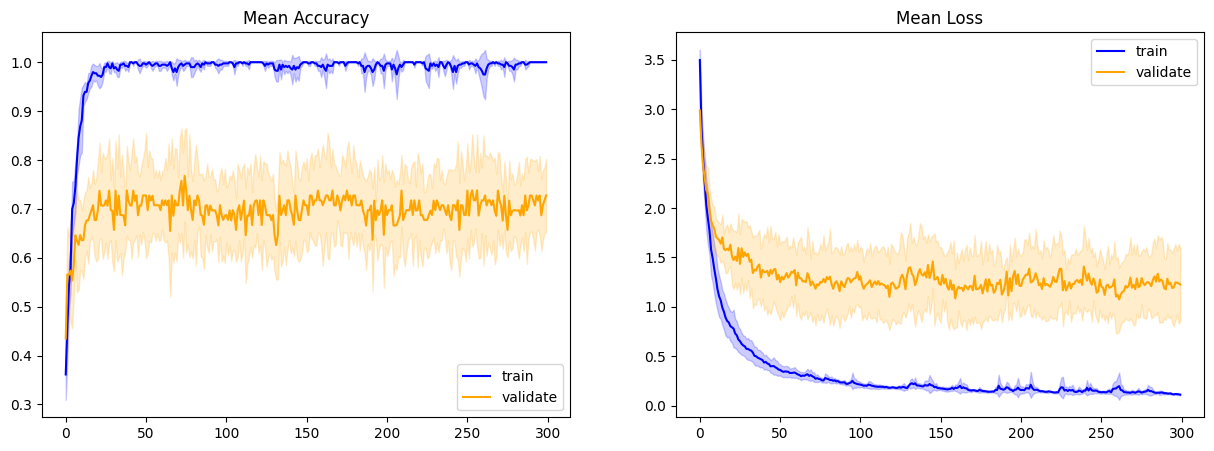

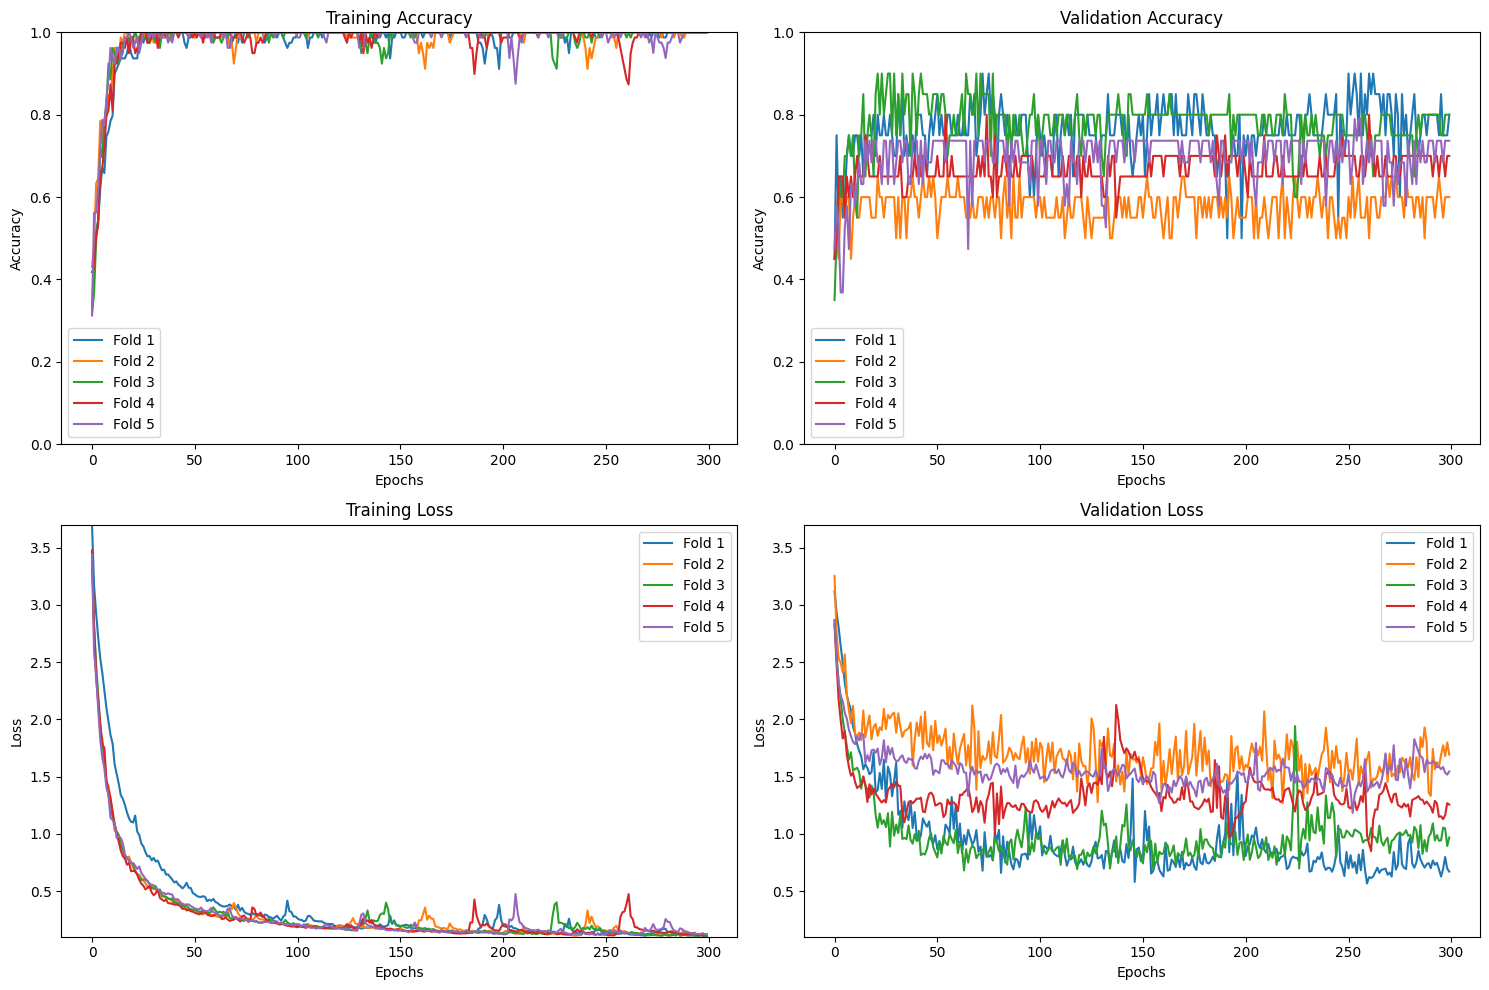

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
predicted classes:       [2 0 2 2 0 0 1 1 2 0 0 2 2 1 2 0 2 0 1]
true validation classes: [2 0 2 2 2 0 1 1 2 0 2 2 2 1 1 2 1 0 1]


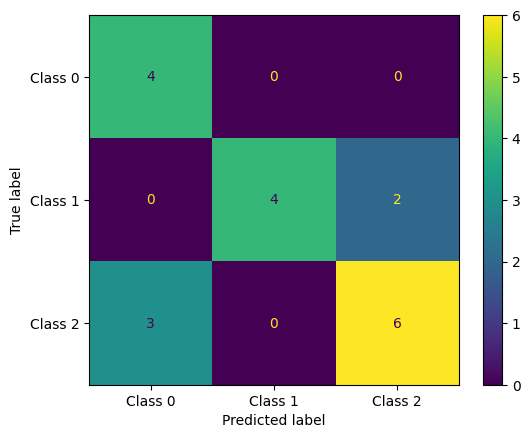

In [36]:
crossvalidate(df_train_val, model3, predictors, 'pond_3', kf)

In [37]:
reset_weights(model3)
es = EarlyStopping(monitor='val_loss', patience=100)
history3=model3.fit(X_train, y_train, epochs = 750, verbose = 0, shuffle = True, validation_data=(X_test, y_test), callbacks = [es])


## model evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8800 - loss: 0.5459
[0.5458593964576721, 0.8799999952316284]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted values: [1 2 2 1 1 1 0 1 2 2 2 1 2 0 2 0 1 0 2 2 0 1 1 1 2]
True values: [1 0 2 1 1 1 0 1 2 2 2 1 2 0 2 1 1 0 2 2 0 1 2 1 2]


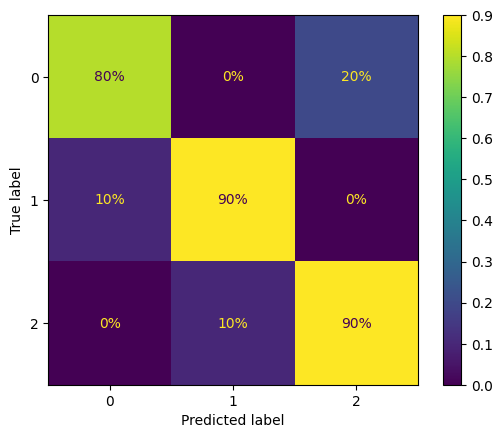

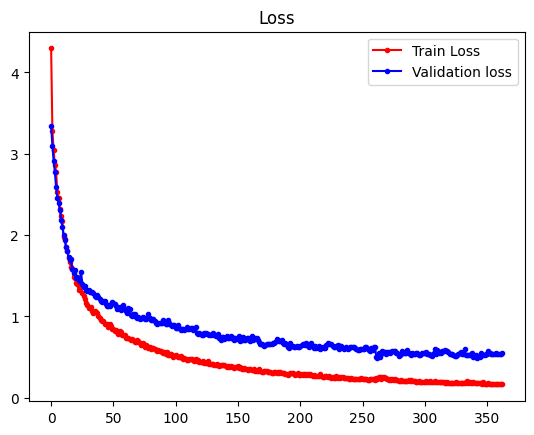

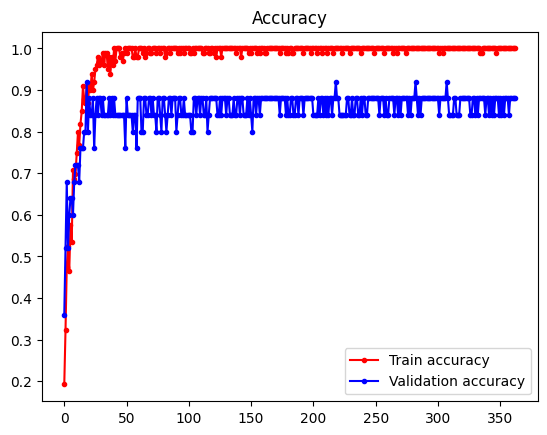

In [38]:
evaluate_model(history = history3, model = model3, X_test = X_test, y_test = y_test, acc_name = "Accuracy", loss_name = "Loss")

To remind ourselves what classes look like 

| number | class | pond numbers | feed suplementation |
|---|---|---|---|
|0|control(0) | 8,14,18,24,29|NO|
|1|1|12,16,19,23,26,9,13,17,20,27|NO|
|2|2| 10,21,28,30,32,11,15,22,25,31|EM|


As we can see this did help a bit, accuracy rised a little (we have to account for smaller number of classes) to around 0.7. Looking at confusion matrix the results for class 2 seems to be alright the problem is with model confusing clas 0 and 1, although it is understandable why model is confusing control with 1 class based on conclusions we draw before that feed suplementation has much more impact it is weird that model is misstaking 0 class as 2 class. We might try binary classification approach based only on feed suplementation without control group. 

# 2 classes
As we mentioned later here we will focus only on 2 classes 
- 0 - no feed classification 
- 1 - feed suplementation 

## model building and compiling

In [39]:
model2 = keras.Sequential()
model2.add(keras.layers.Dense(128, input_shape=(len(predictors),), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
model2.add(keras.layers.Dense(16, activation ='relu',kernel_regularizer=keras.regularizers.l2(0.01)))

model2.add(keras.layers.Dense(2, activation ='softmax'))

model2.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,586 (99.95 KB)

 Trainable params: 25,586 (99.95 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## Crossvalidation


Number of classes: 2
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8500 - loss: 0.4068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted classes:       [0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1]
true validation classes: [0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1]
mean confidence score: 803.4885, sd confidence score: 1447.5155
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8000 - loss: 0.6654
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicted classes:       [0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0]
true validation classes: [0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0]
mean confidence score: 586.8863, sd confidence score: 1028.1205
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8500 - loss: 0.6363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predicted classes:       [0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0]
true validation classes: [0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0]
mean confidence score: 14747.9016, sd confidence sco

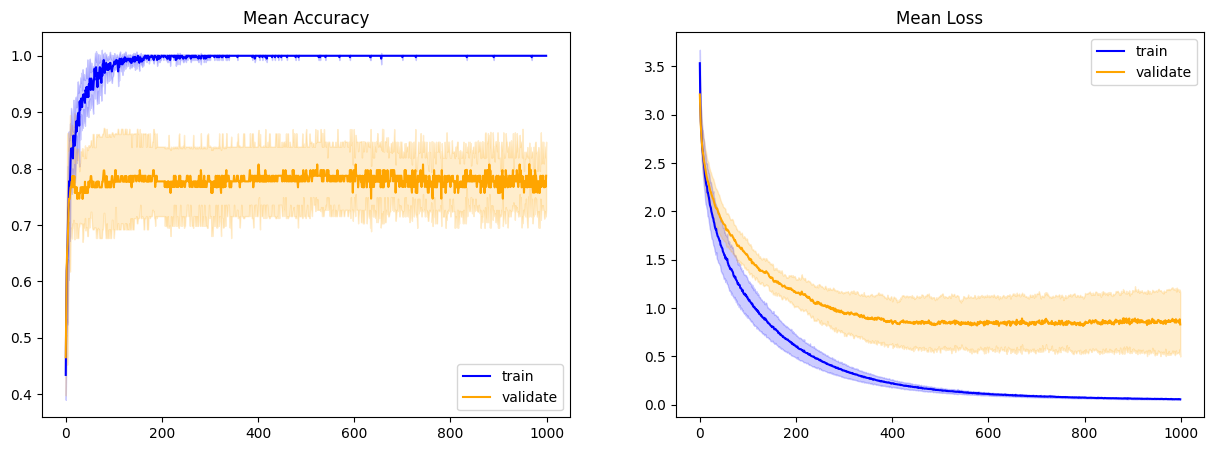

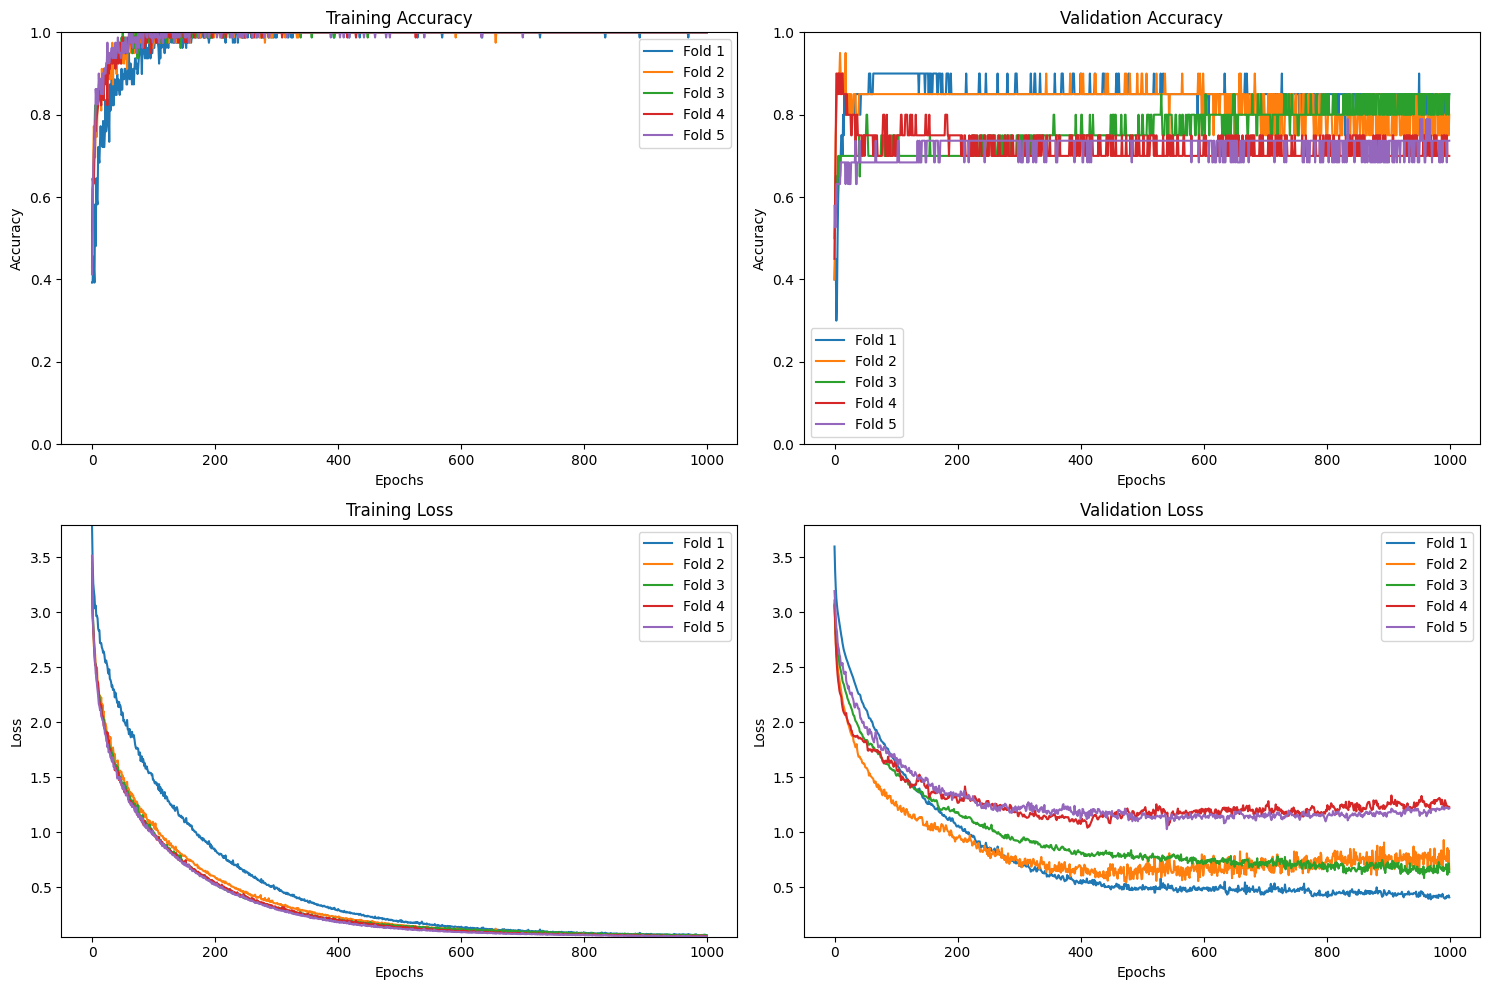

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0]
true validation classes: [1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0]


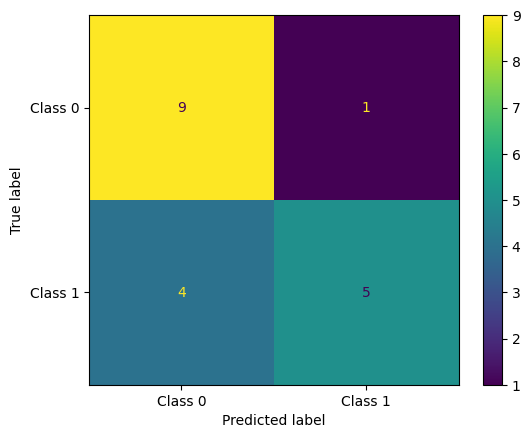

In [41]:
crossvalidate(df_train_val, model2, predictors, 'pond_2', kf, epochs=1000)

In [42]:
y_train = keras.utils.to_categorical(df_train_val['pond_2'].values)
y_test = keras.utils.to_categorical(df_test['pond_2'].values)

In [43]:
reset_weights(model2)
history2=model2.fit(X_train, y_train, epochs = 750, verbose = 0, shuffle = True, validation_data=(X_test, y_test), callbacks = [es])

## model evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8000 - loss: 1.7342
[1.7341904640197754, 0.800000011920929]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted values: [0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1]
True values: [0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1]


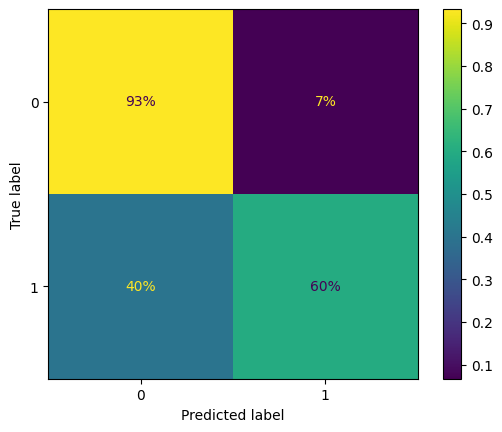

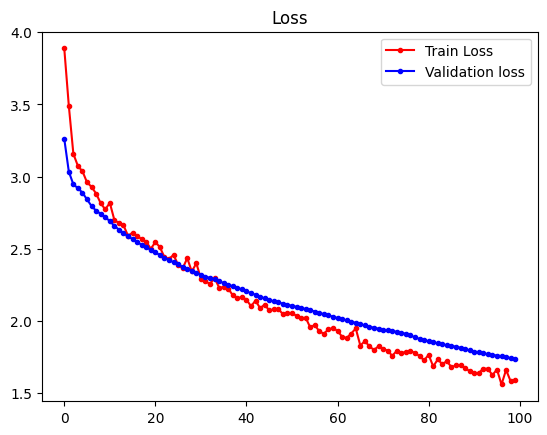

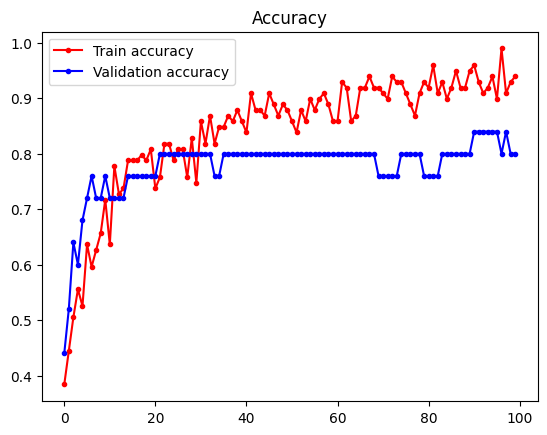

In [44]:
evaluate_model(history = history2, model = model2, X_test = X_test, y_test = y_test, acc_name = "Accuracy", loss_name = "Loss")

To remind ourselves what the current classes look like 

| number | class | pond numbers | feed suplementation |
|---|---|---|---|
|0|0|8,14,18,24,29,12,16,19,23,26,9,13,17,20,27|NO|
|1|1| 10,21,28,30,32,11,15,22,25,31|YES|

We can see quite good accuracy of 0.9 although we reducend number of classes this combined with probably more accurate biological classes made results quite good. We will now perform comparison with XGBoost classification tool to get the alternative results. 

# XGBoost comparison

## 5 classes

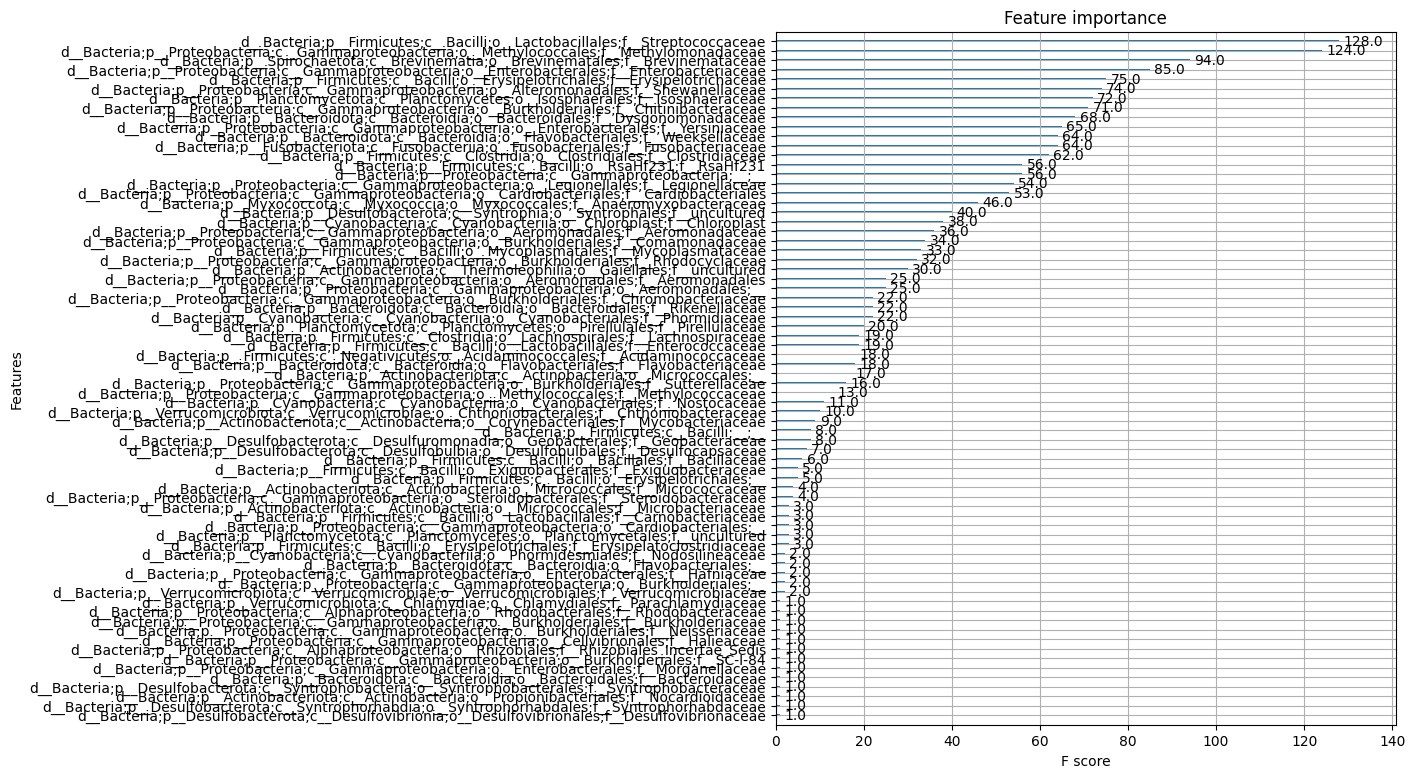

Accuracy0.56
true: [3 0 2 1 3 1 0 1 2 2 4 3 4 0 4 1 3 0 2 4 0 1 4 3 2]
predicted: [1. 0. 2. 1. 0. 4. 0. 1. 2. 1. 1. 3. 2. 0. 2. 1. 4. 0. 1. 4. 1. 1. 1. 3.
 2.]


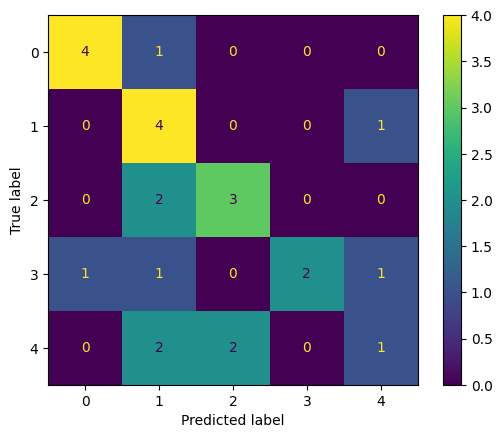

In [45]:
target = "pond_5"
dtrain = xgb.DMatrix(X_train, label=df_train_val[target].values, feature_names=predictors.to_list())  
dtest = xgb.DMatrix(X_test, label=df_test[target].values, feature_names=predictors.to_list())
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111
}

x2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = x2.predict(dtest)
xgb_acc = accuracy_score(df_test[target].values, xgb_pred)
fig, ax = plt.subplots(figsize=(8, 9))
xgb.plot_importance(x2, ax=ax)
plt.show()

print(f"Accuracy{xgb_acc}")
print(f"true: {df_test[target].values}")
print(f"predicted: {xgb_pred}")

cm = confusion_matrix(df_test[target].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

## 3 Classes

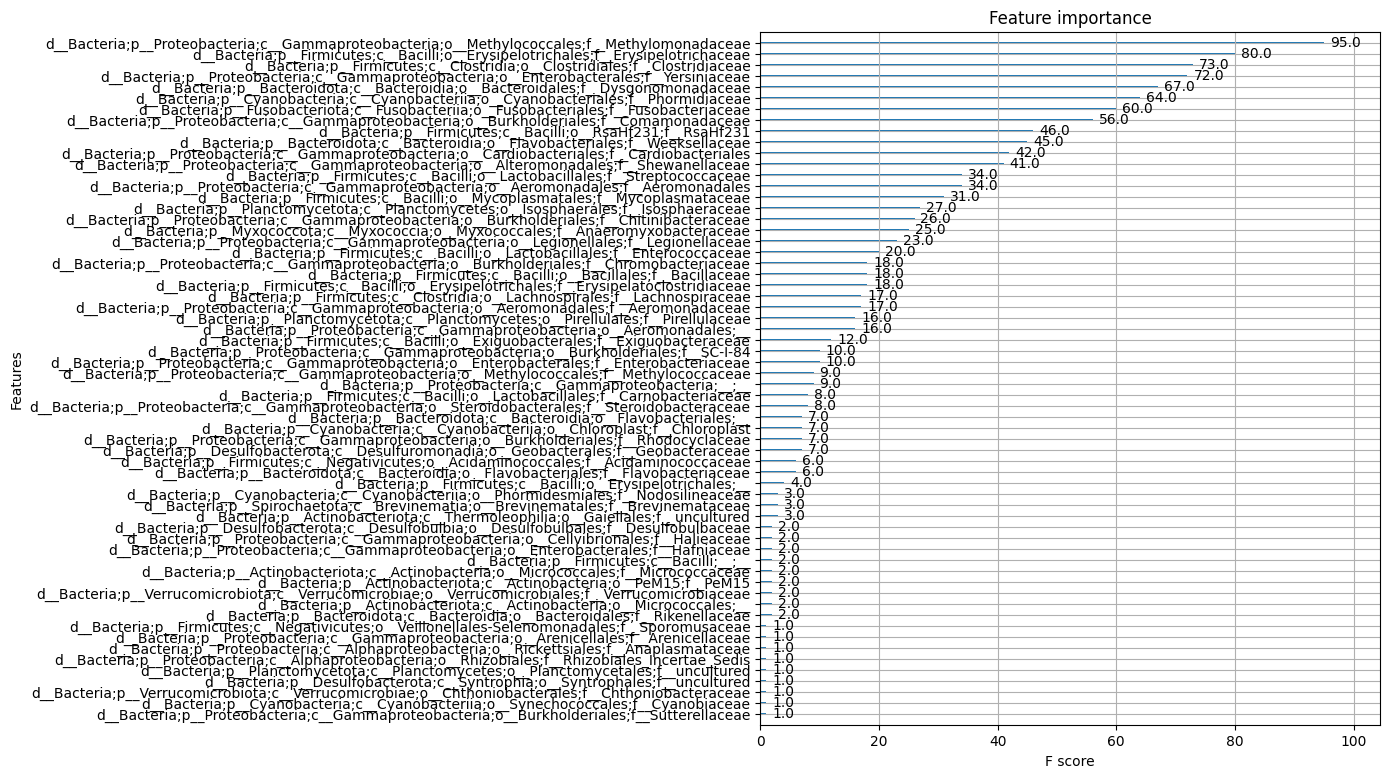

Accuracy0.64
true: [1 0 2 1 1 1 0 1 2 2 2 1 2 0 2 1 1 0 2 2 0 1 2 1 2]
predicted: [1. 0. 2. 1. 0. 1. 0. 1. 1. 0. 2. 2. 2. 1. 2. 1. 2. 1. 2. 2. 1. 1. 1. 1.
 2.]


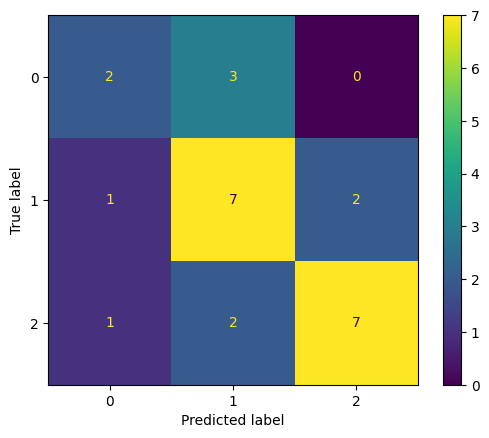

In [46]:
target = "pond_3"
dtrain = xgb.DMatrix(X_train, label=df_train_val[target].values, feature_names=predictors.to_list())  
dtest = xgb.DMatrix(X_test, label=df_test[target].values, feature_names=predictors.to_list())
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, 
    'eta': 0.1,
    'seed': 111
}

x2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = x2.predict(dtest)
xgb_acc = accuracy_score(df_test[target].values, xgb_pred)

fig, ax = plt.subplots(figsize=(8, 9))  
xgb.plot_importance(x2, ax=ax)
plt.show()
print(f"Accuracy{xgb_acc}")
print(f"true: {df_test[target].values}")
print(f"predicted: {xgb_pred}")

cm = confusion_matrix(df_test[target].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

## 2 Classes

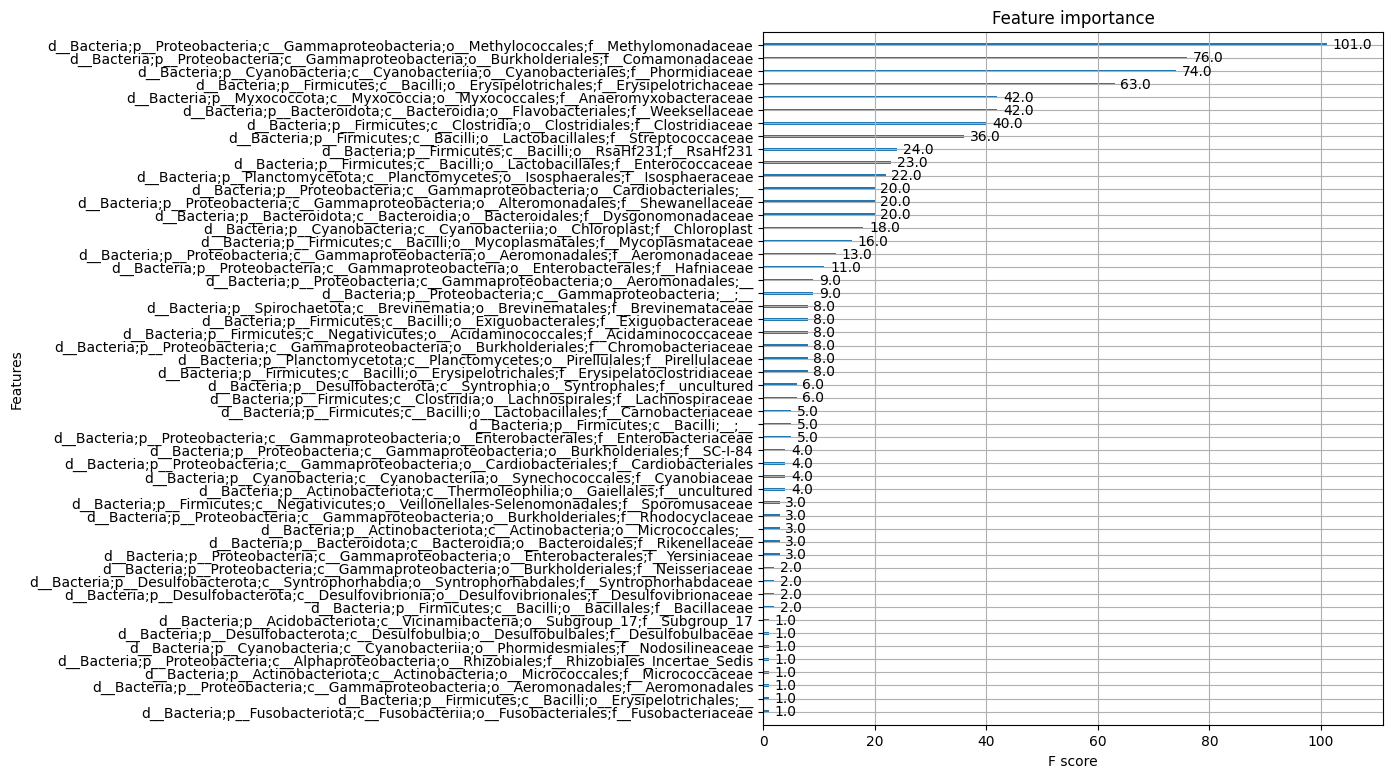

Accuracy0.84
true: [0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1]
predicted: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 1.]


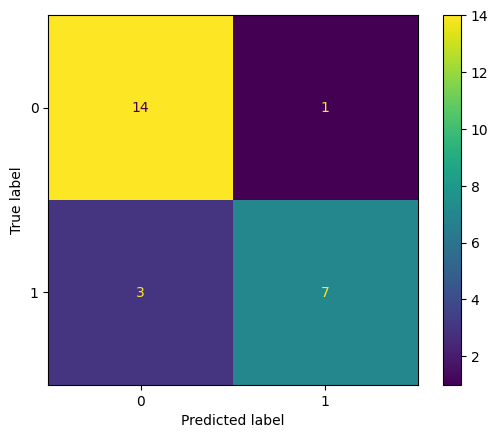

In [47]:
target = "pond_2"
dtrain = xgb.DMatrix(X_train, label=df_train_val[target].values, feature_names=predictors.to_list())  
dtest = xgb.DMatrix(X_test, label=df_test[target].values, feature_names=predictors.to_list())
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, 
    'eta': 0.1,
    'seed': 111
}

x2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = x2.predict(dtest)
xgb_acc = accuracy_score(df_test[target].values, xgb_pred)

fig, ax = plt.subplots(figsize=(8, 9))  
xgb.plot_importance(x2, ax=ax)
plt.show()

print(f"Accuracy{xgb_acc}")
print(f"true: {df_test[target].values}")
print(f"predicted: {xgb_pred}")

cm = confusion_matrix(df_test[target].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()